In [1]:
%load_ext autoreload
%autoreload 2

In [300]:
import pandas as pd
import numpy as np
import json
import os
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
import re
import seaborn as sns
import matplotlib.pyplot as plt
import swifter
import multiprocessing
import time
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.formula.api as smf
sns.set_style("darkgrid")

## Loading Processed Reviews

In [5]:
# Paths
PROCESSED_FOLDER = './data/processed/'
PROCESSED_REVIEWS_FILE = 'processed_reviews.csv'

In [4]:
reviews = pd.read_csv(os.path.join(PROCESSED_FOLDER, PROCESSED_REVIEWS_FILE))

In [7]:
reviews.head()

,review_id,user_id,item_id,text,rating,tokenized_text
0,255938,0,1,"First things first. My ""reviews"" system is exp...",8,"[['First', 'things', 'first', '.'], ['My', '``..."
1,259117,1,2,Let me start off by saying that Made in Abyss ...,10,"[['Let', 'me', 'start', 'off', 'by', 'saying',..."
2,253664,2,3,"Art 9/10: It is great, especially the actions ...",7,"[['Art', '9/10', ':', 'It', 'is', 'great', ','..."
3,247454,3,4,As someone who loves Studio Ghibli and its mov...,6,"[['As', 'someone', 'who', 'loves', 'Studio', '..."
4,23791,4,5,code geass is one of those series that everybo...,10,"[['code', 'geass', 'is', 'one', 'of', 'those',..."


# Basic Sentiment Regression
In this section, we examine whether there is a relationship between textual features and the rating that a user gives. Note that this is an easier task to recommendation—when you are recommending hidden items, you do not have access to a user's review

## Setting up Vader

In [118]:
analyzer = SentimentIntensityAnalyzer()

def analyze(s: str) -> dict:
    return analyzer.polarity_scores(s)

def analyze_sentence_average(paragraph: str) -> dict:
    """Uses sent_tokenize from nltk_tokenize, then averages together sentiment of each sentence"""
    neg_scores = []
    neu_scores = []
    pos_scores = []
    compound_scores = []
    
    for sent in sent_tokenize(paragraph):
        scores = list(analyze(sent).values())
        neg_scores.append(scores[0])
        neu_scores.append(scores[1])
        pos_scores.append(scores[2])
        compound_scores.append(scores[3])

    avg_dict = {
        'neg': np.mean(neg_scores),
        'neu': np.mean(neu_scores),
        'pos': np.mean(pos_scores),
        'compound': np.mean(compound_scores)
    }
    
    return avg_dict

In [92]:
# example
text = "Hi I really hated this show"
print(analyze(text))
print(analyze_sentence_average(text))

{'neg': 0.473, 'neu': 0.527, 'pos': 0.0, 'compound': -0.6697}
{'neg': 0.473, 'neu': 0.527, 'pos': 0.0, 'compound': -0.6697}


## Generating Scores for All Reviews

In [64]:
df = reviews.copy()

In [126]:
df['neg'] = df['text'][:100].swifter.allow_dask_on_strings(True).apply(lambda x: analyze(x)['neg'])

Dask Apply:   0%|          | 0/25 [00:00<?, ?it/s]

In [ ]:
df['pos'] = df['text'].swifter.allow_dask_on_strings(True).apply(lambda x: analyze(x)['pos'])

In [ ]:
df['compound'] = df['text'].swifter.allow_dask_on_strings(True).apply(lambda x: analyze(x)['compound'])

In [120]:
df['neg_sent_avg'] = df['text'].swifter.allow_dask_on_strings(True).apply(lambda x: analyze_sentence_average(x)['neg'])

Pandas Apply:   0%|          | 0/35612 [00:00<?, ?it/s]

In [295]:
df['neu_sent_avg'] = df['text'].swifter.allow_dask_on_strings(True).apply(lambda x: analyze_sentence_average(x)['neu'])

Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

In [121]:
df['pos_sent_avg'] = df['text'].swifter.allow_dask_on_strings(True).apply(lambda x: analyze_sentence_average(x)['pos'])

Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

In [122]:
df['compound_sent_avg'] = df['text'].swifter.allow_dask_on_strings(True).apply(lambda x: analyze_sentence_average(x)['compound'])

Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

## Saving generated scores

In [123]:
print("Saving Reviews w/ Sentiment...")
df.to_csv(os.path.join(PROCESSED_FOLDER, "processed_reviews_with_sentiment.csv"), index=False)
print("Done")

Saving Reviews w/ Sentiment...
Done


In [124]:
pd.read_csv(os.path.join(PROCESSED_FOLDER, "processed_reviews_with_sentiment.csv")).head()

,review_id,user_id,item_id,text,rating,tokenized_text,neg,neg_sent_avg,pos_sent_avg,compound_sent_avg
0,255938,0,1,"First things first. My ""reviews"" system is exp...",8,"[['First', 'things', 'first', '.'], ['My', '``...",0.094,0.073333,0.168937,0.208675
1,259117,1,2,Let me start off by saying that Made in Abyss ...,10,"[['Let', 'me', 'start', 'off', 'by', 'saying',...",0.081,0.062741,0.177963,0.302804
2,253664,2,3,"Art 9/10: It is great, especially the actions ...",7,"[['Art', '9/10', ':', 'It', 'is', 'great', ','...",0.051,0.047278,0.159833,0.220767
3,247454,3,4,As someone who loves Studio Ghibli and its mov...,6,"[['As', 'someone', 'who', 'loves', 'Studio', '...",0.083,0.055577,0.135269,0.187896
4,23791,4,5,code geass is one of those series that everybo...,10,"[['code', 'geass', 'is', 'one', 'of', 'those',...",0.016,0.028857,0.248143,0.534129


## Plot Helpers

In [278]:
def regplot_helper(df, x, y, x_bins):   
    corr = df[x].corr(df[y])
    r_squared = corr**2
    
    p = sns.regplot(x=x, y=y, data=df, x_bins=x_bins, line_kws={
        'label': f"r = {round(corr, 3)}\nr^2={round(r_squared, 3)}",
    })
    p.set(title=f"{y} vs {x}")
    plt.legend()
    return p

## Review Rating vs Negative Sentiment

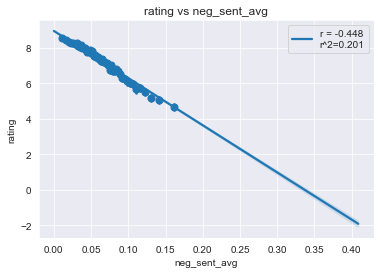

In [279]:
p = regplot_helper(df, 'neg_sent_avg', 'rating', x_bins=50)

## Review Rating vs Neutral Sentiment

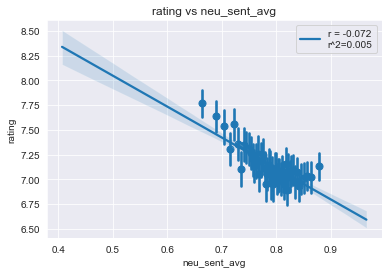

In [296]:
p = regplot_helper(df, 'neu_sent_avg', 'rating', x_bins=50)

## Review Rating vs Positive Sentiment

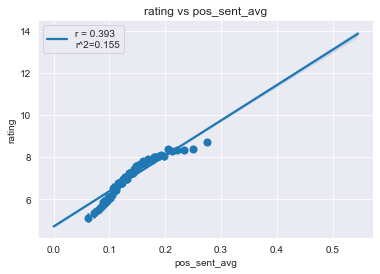

In [280]:
p = regplot_helper(df, 'pos_sent_avg', 'rating', x_bins=50)

## Review Rating vs Compound Sentiment

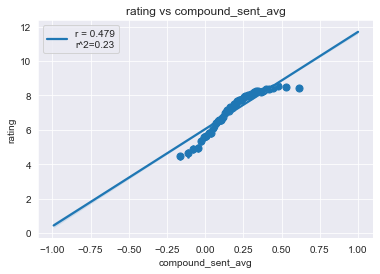

In [281]:
p = regplot_helper(df, 'compound_sent_avg', 'rating', x_bins=50)

## Wrap-up, using all three factors

In [363]:
X = df[['neg_sent_avg', 'pos_sent_avg', 'compound_sent_avg']]
y = df['rating']
reg = LinearRegression().fit(X, y)
reg.score(X, y)

0.26471342837215994

### P-value is extremely significant

In [364]:
model = smf.ols('rating ~ neg_sent_avg + pos_sent_avg + compound_sent_avg', data=df)
fit = model.fit()

In [366]:
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.265
Model:                            OLS   Adj. R-squared:                  0.265
Method:                 Least Squares   F-statistic:                     4273.
Date:                Sat, 30 Apr 2022   Prob (F-statistic):               0.00
Time:                        06:15:11   Log-Likelihood:                -72755.
No. Observations:               35612   AIC:                         1.455e+05
Df Residuals:                   35608   BIC:                         1.456e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             6.7602      0.044    151.943      0.000       6.673       6.847
neg_sent_avg        -15.6382      0.403    -38.758      0.000     -16.429     -14.847
pos_sent_avg          7.2976      0.297     24.609      0.000       6.716       7.879
compound_sent_avg     1.9498      0.108     17.984      0.000       1.737       2.162
==============================================================================
Omnibus:                      790.055   Durbin-Watson:                   1.632
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              843.398
Skew:                          -0.371   Prob(JB):                    7.22e-184
Kurtosis:                       3.132   Cond. No.                         44.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [367]:
fit.pvalues

Intercept             0.000000e+00
neg_sent_avg          0.000000e+00
pos_sent_avg         1.308028e-132
compound_sent_avg     5.407344e-72
dtype: float64

## User Similarity